# GARCH Modelling Assignment

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm_api
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from arch import arch_model, unitroot
from statsmodels.stats import stattools
from scipy.stats import jarque_bera
from datetime import datetime

## 1.Loading of the price data file

In [4]:
# Load the data
file_path = "IndexClosingPrices.xlsx"
data = pd.read_excel(file_path, index_col=0, parse_dates=True)
print(data.head())

             SP500    ASX    DAX
Date                            
1980-01-02  105.76  516.4  493.5
1980-01-03  105.22  523.5  485.7
1980-01-04  106.52  513.5  491.8
1980-01-07  106.81  518.1  492.5
1980-01-08  108.95  515.7  494.1


## 2.Creation of return data for each index

In [6]:
# Compute log returns for each index
returns = np.log(data / data.shift(1)).dropna() * 100

In [7]:
# Compute simple returns for each index
simple_returns = (data / data.shift(1) - 1).dropna() * 100

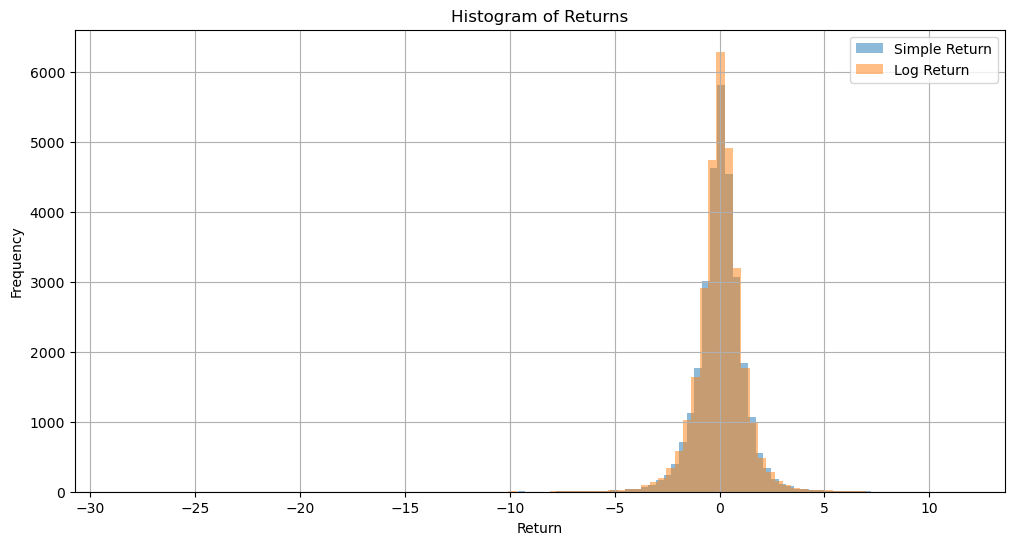

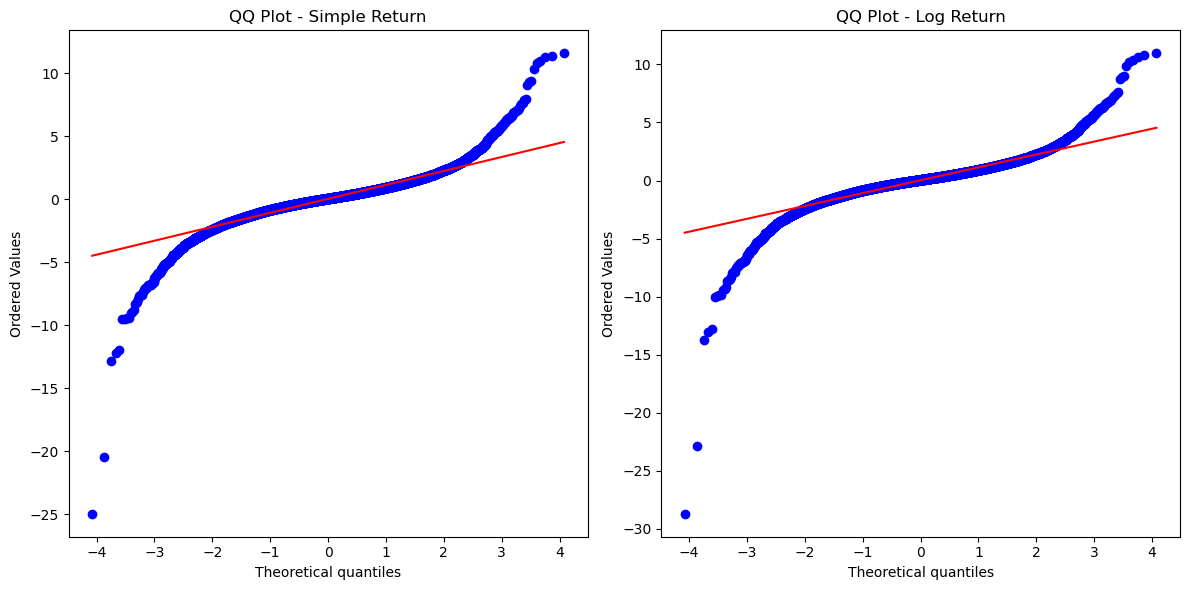

In [8]:
# Plot histogram for Simple and Log Returns
plt.figure(figsize=(12, 6))
plt.hist(simple_returns.values.flatten(), bins=100, alpha=0.5, label="Simple Return")
plt.hist(returns.values.flatten(), bins=100, alpha=0.5, label="Log Return")
plt.title("Histogram of Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# QQ Plot for Simple and Log Returns
plt.figure(figsize=(12, 6))

# Simple Return QQ Plot
plt.subplot(1, 2, 1)
stats.probplot(simple_returns.values.flatten(), dist="norm", plot=plt)
plt.title("QQ Plot - Simple Return")

# Log Return QQ Plot
plt.subplot(1, 2, 2)
stats.probplot(returns.values.flatten(), dist="norm", plot=plt)
plt.title("QQ Plot - Log Return")

plt.tight_layout()
plt.show()


## 3.Plots of both the price and return series

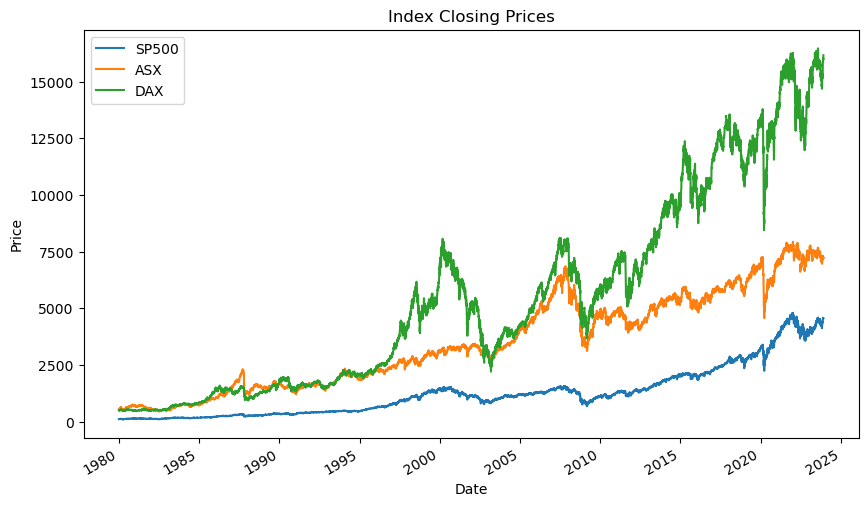

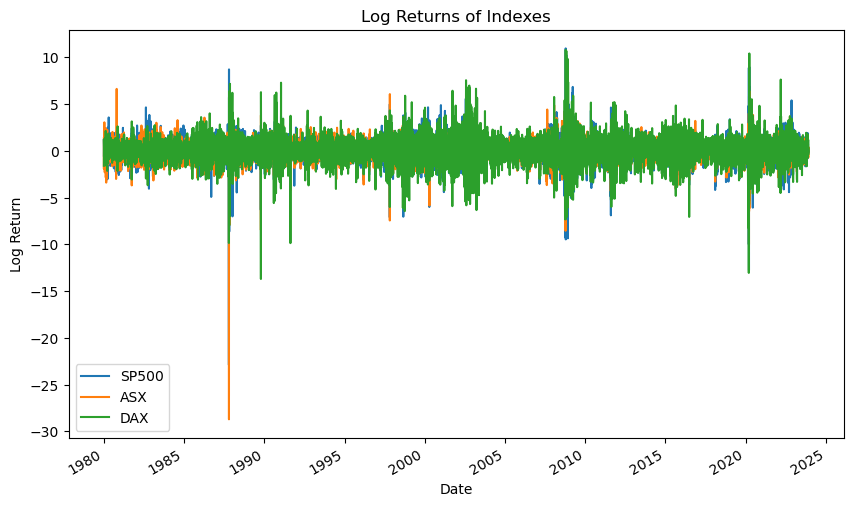

In [10]:
# Plot the original price series
data.plot(title="Index Closing Prices", figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# Plot the returns series
returns.plot(title="Log Returns of Indexes", figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

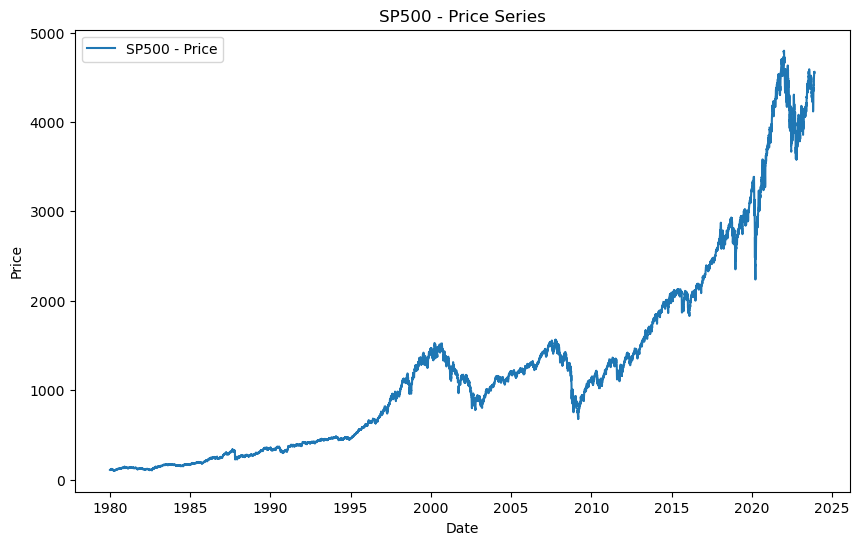

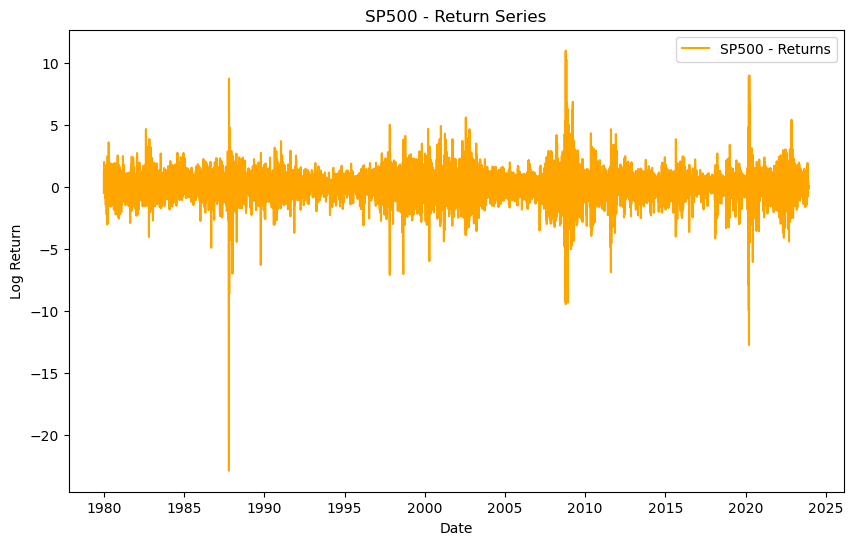

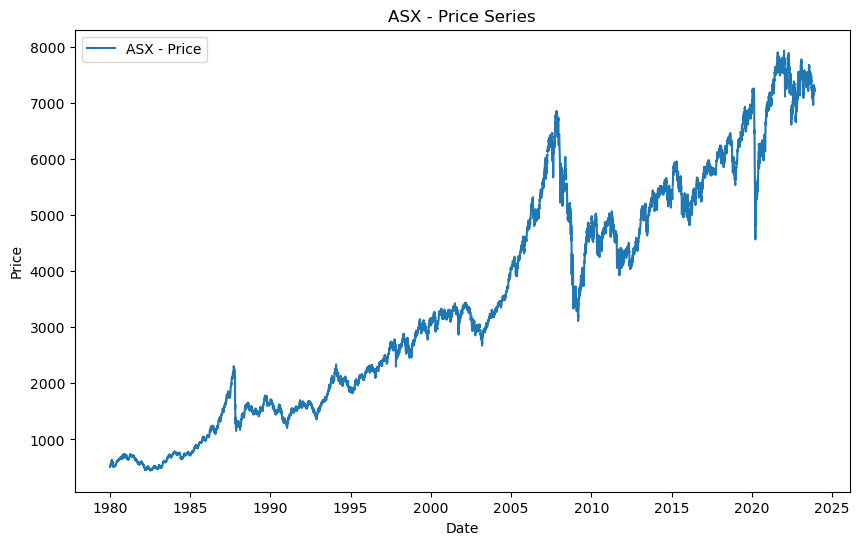

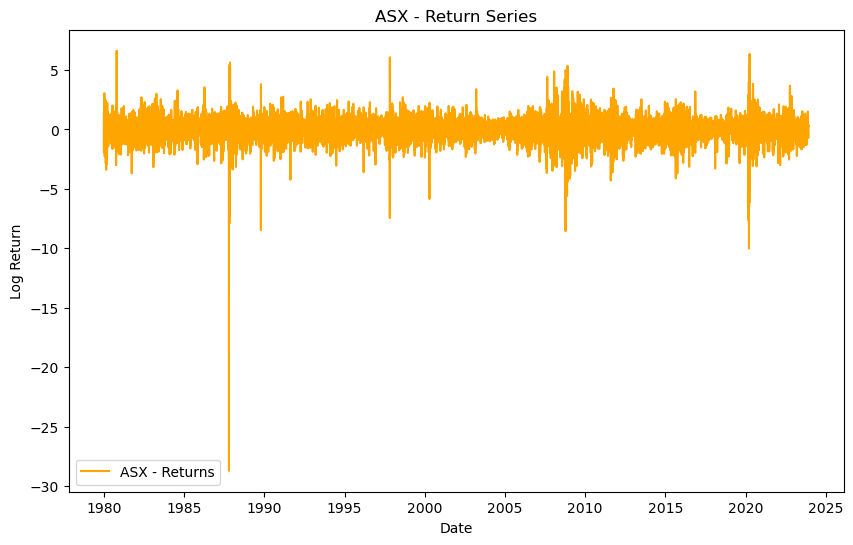

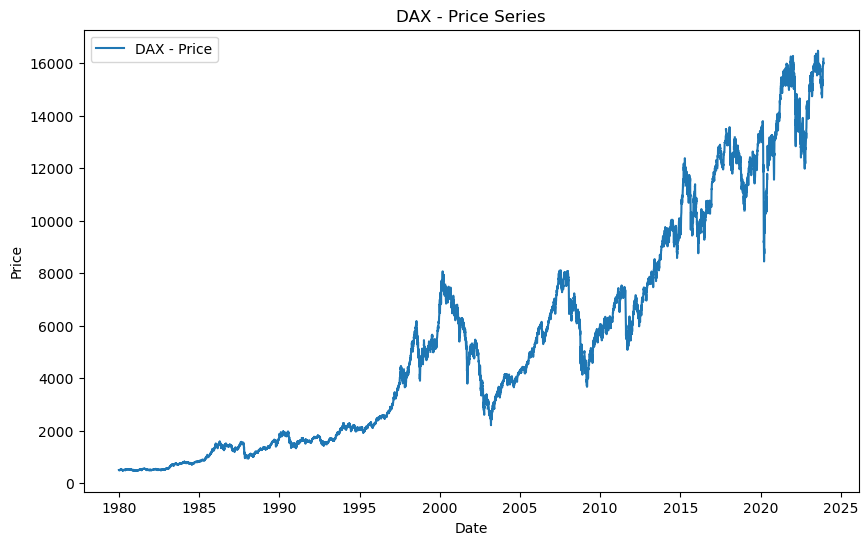

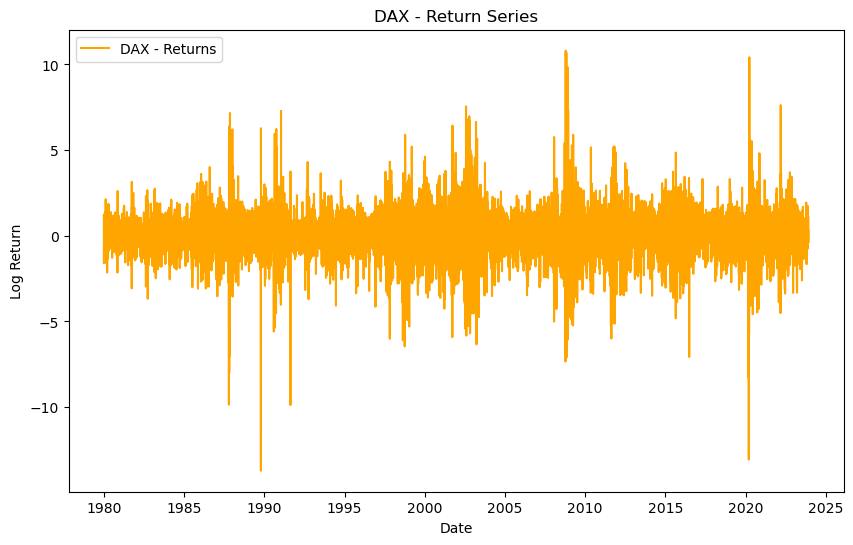

In [11]:
indices = data.columns[:6]

for i, col in enumerate(indices):     #indices[i]=col
    # Plot price series for the current index
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data[col], label=f'{col} - Price')
    plt.title(f'{col} - Price Series')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
    # Plot return series for the current index
    plt.figure(figsize=(10, 6))
    plt.plot(returns.index, returns[col], label=f'{col} - Returns', color='orange')
    plt.title(f'{col} - Return Series')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.legend()
    plt.show()

## Increased time limits 

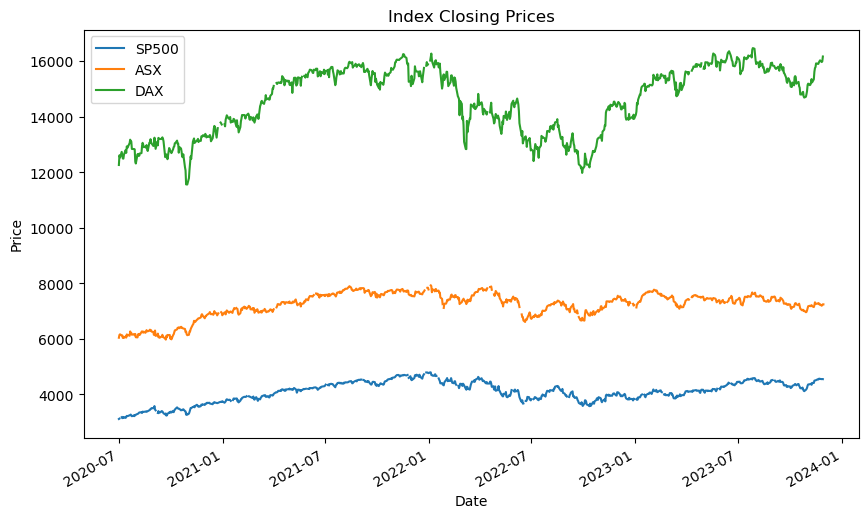

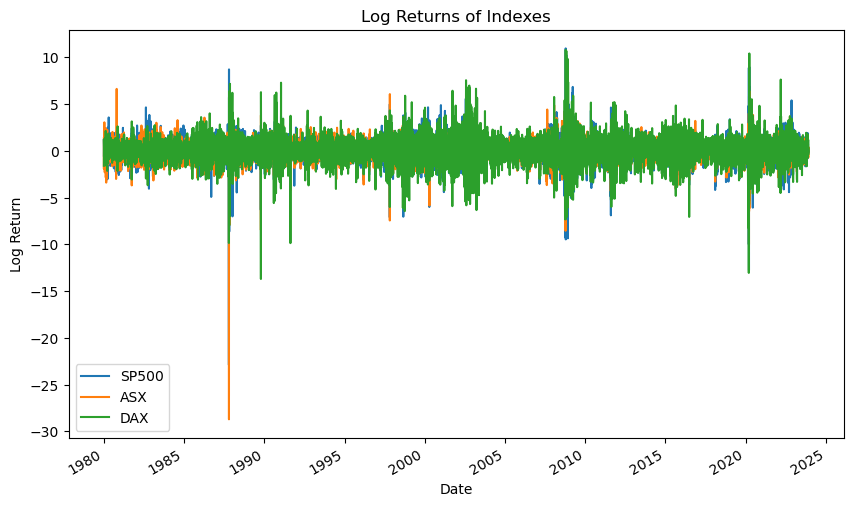

In [13]:
#Increased time limits to reduce the impact of abnormal fluctuations
data = data[data.index >= datetime(2020,7,1)]

# Plot the original price series
data.plot(title="Index Closing Prices", figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# Plot the returns series
returns.plot(title="Log Returns of Indexes", figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

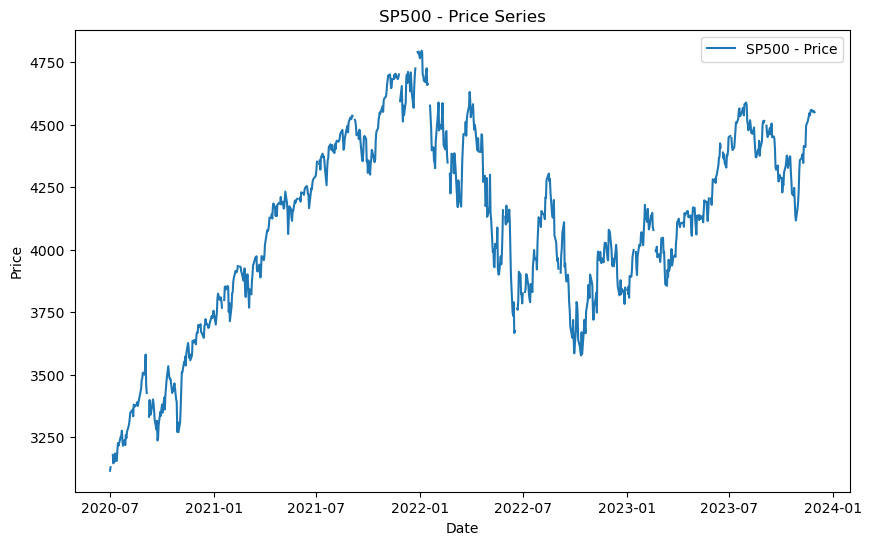

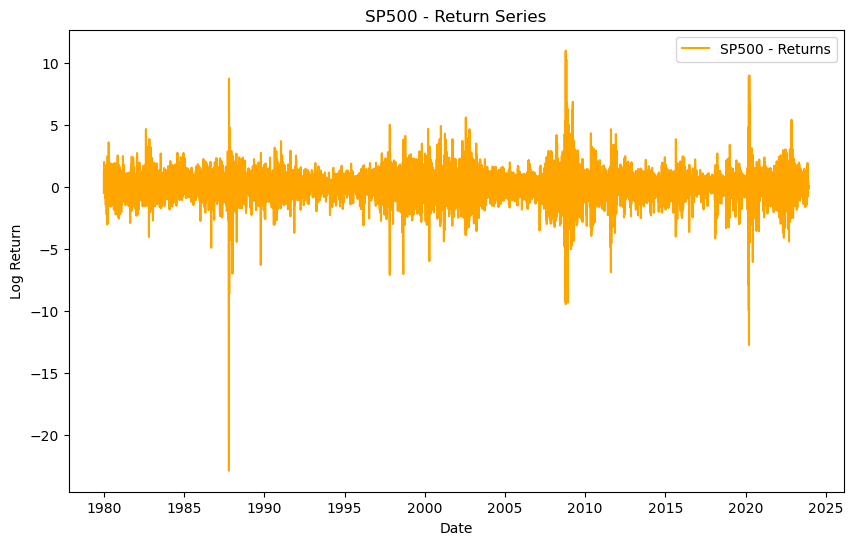

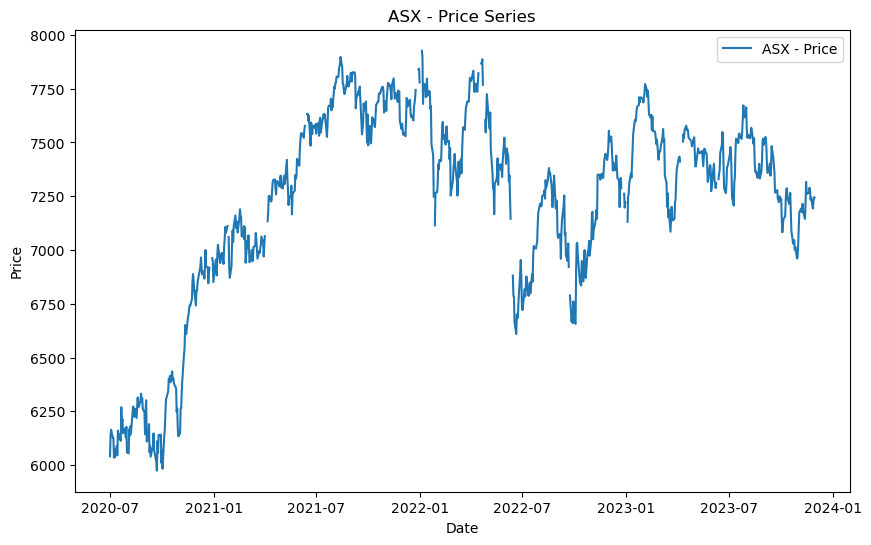

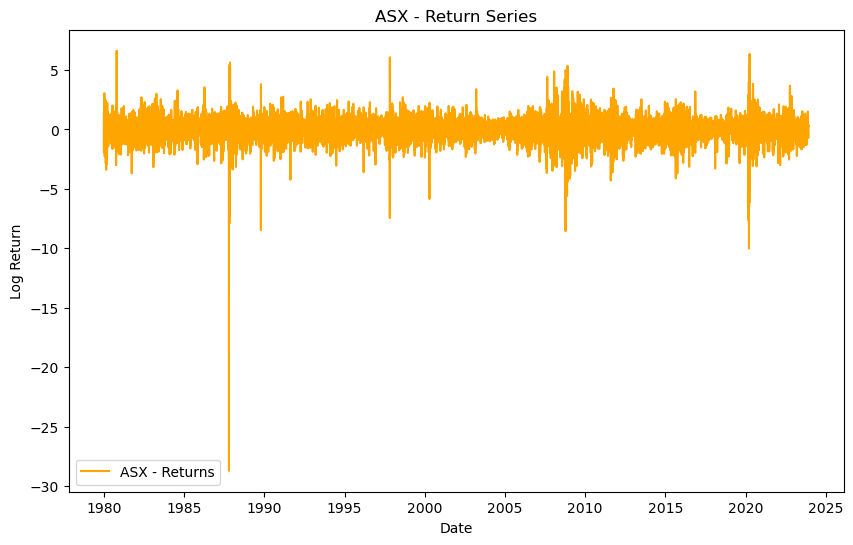

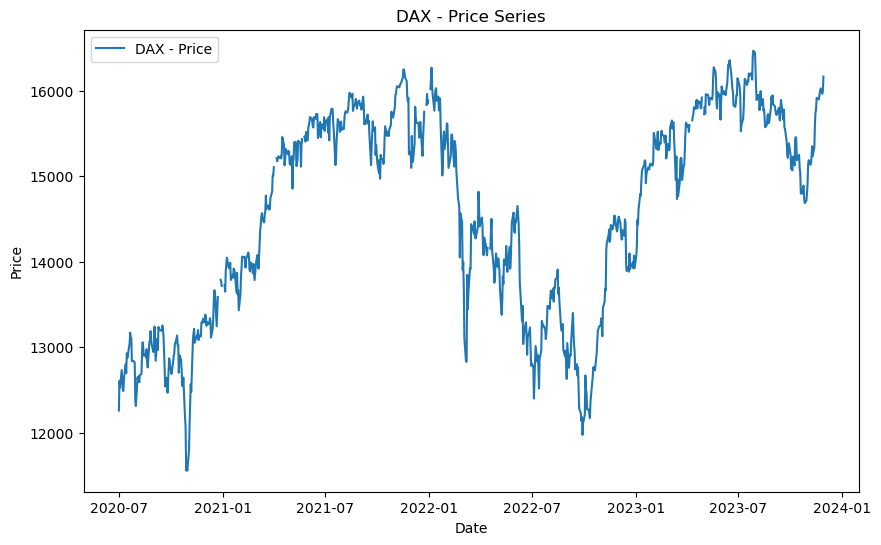

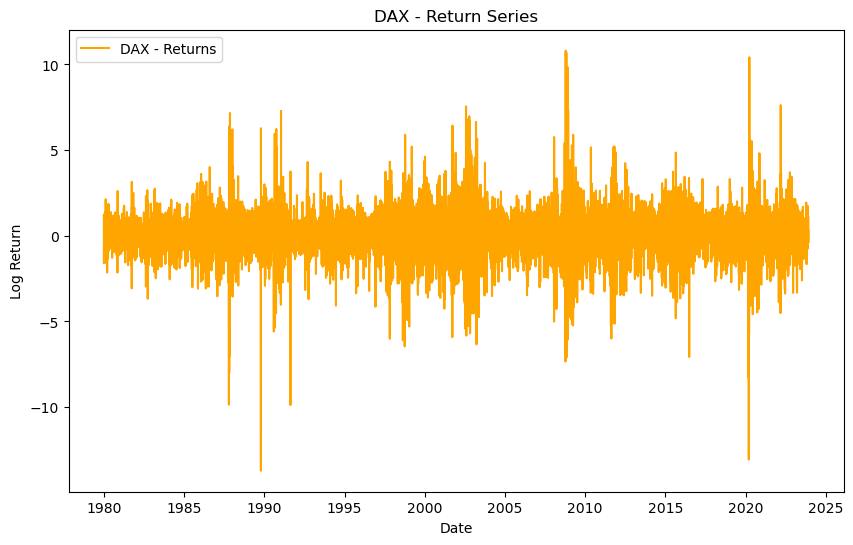

In [14]:
indices = data.columns[:6]

for i, col in enumerate(indices):     #indices[i]=col
    # Plot price series for the current index
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data[col], label=f'{col} - Price')
    plt.title(f'{col} - Price Series')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
    # Plot return series for the current index
    plt.figure(figsize=(10, 6))
    plt.plot(returns.index, returns[col], label=f'{col} - Returns', color='orange')
    plt.title(f'{col} - Return Series')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.legend()
    plt.show()

## 4.Use of the Dickey-Fuller test to check that the returns series’ are stationary

In [16]:
# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series)
    return result[1]  # Return the p-value
# Apply the Dickey-Fuller test to each return series
stationarity_results = {col: check_stationarity(returns[col]) for col in returns.columns}
print("Dickey-Fuller Test Results (p-values):", stationarity_results)

#Test for stationarity using the augmented Dickey-Fuller unit root test
for column in returns.columns:
  adf_test = unitroot.ADF(returns[column])
  print(f"Dickey-Fuller unit root test: {column}")
  print(adf_test.summary())
  print()

# The series is weakly stationary, which is sufficient for modelled using GARCH.

Dickey-Fuller Test Results (p-values): {'SP500': 7.665914289863292e-30, 'ASX': 0.0, 'DAX': 0.0}
Dickey-Fuller unit root test: SP500
   Augmented Dickey-Fuller Results   
Test Statistic                -17.085
P-value                         0.000
Lags                               34
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Dickey-Fuller unit root test: ASX
   Augmented Dickey-Fuller Results   
Test Statistic                -20.840
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Dickey-Fuller unit root test: DAX
   Augmented Dickey-Fuller Results   
Test Statistic        

## 5.An output showing the parameters of the fitted models

## 5-1.mean='constant', vol='Garch', p=1, q=1,dist="Normal"

In [19]:
# Initialize an empty dictionary to store the fitted GARCH model results for each column
garch_results = {}

# Loop through each column in the returns DataFrame (each column represents a different index)
for column in returns.columns:
    # Define a GARCH(1,1) model for the current index's return series
    # mean=constant means us constant value as it's mean
    # vol='Garch' specifies that we are using the GARCH model
    # p=1 and q=1 define the lag orders for the GARCH model
    model = arch_model(returns[column], mean='constant', vol='Garch', p=1, q=1,dist="Normal")
    
    # Fit the GARCH model to the return series
    # disp="off" suppresses the fitting output for cleaner display
    fitted_model = model.fit(disp="off")
    
    # Store the fitted model in the dictionary with the column name as the key
    garch_results[column] = fitted_model
    
    # Print the column name to indicate which index's model summary is being displayed
    print(f"Model summary for {column}:")
    
    # Print the summary of the fitted GARCH(1,1) model, which includes key parameters and statistics
    print(fitted_model.summary())


Model summary for SP500:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  SP500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -13546.0
Distribution:                  Normal   AIC:                           27100.1
Method:            Maximum Likelihood   BIC:                           27128.9
                                        No. Observations:                10070
Date:                Wed, Dec 11 2024   Df Residuals:                    10069
Time:                        00:53:09   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0616  8.530e-03 

In [20]:
# Fit the model and store parameters for each index
garch_results = {}

for col in returns.columns:
    print(f"Fitting GARCH(1,1) model for {col}：")
    model = arch_model(returns[col], vol='Garch', p=1, q=1)
    fit = model.fit(disp="off")  # Suppress output
    garch_results[col] = fit.params  # Store the model parameters
    print(f"Model parameters for {col}:\n{fit.params}\n")

Fitting GARCH(1,1) model for SP500：
Model parameters for SP500:
mu          0.061580
omega       0.022881
alpha[1]    0.109623
beta[1]     0.872757
Name: params, dtype: float64

Fitting GARCH(1,1) model for ASX：
Model parameters for ASX:
mu          0.049342
omega       0.040951
alpha[1]    0.169580
beta[1]     0.793785
Name: params, dtype: float64

Fitting GARCH(1,1) model for DAX：
Model parameters for DAX:
mu          0.058556
omega       0.036498
alpha[1]    0.104902
beta[1]     0.875516
Name: params, dtype: float64



## 5-2.mean='constant', vol='Garch', p=1, q=1,dist="studentsT"

In [22]:
# Initialize an empty dictionary to store the fitted GARCH model results for each column
garch_results_t = {}

# Loop through each column in the returns DataFrame (each column represents a different index)
for column in returns.columns:
    # Define a GARCH(1,1) model for the current index's return series
    # mean=constant means us constant value as it's mean
    # vol='Garch' specifies that we are using the GARCH model
    # p=1 and q=1 define the lag orders for the GARCH model
    model_t = arch_model(returns[column], mean='constant', vol='Garch', p=1, q=1,dist="studentsT")
    
    # Fit the GARCH model to the return series
    # disp="off" suppresses the fitting output for cleaner display
    fitted_model_t = model_t.fit(disp="off")
    
    # Store the fitted model in the dictionary with the column name as the key
    garch_results_t[column] = fitted_model_t
    
    # Print the column name to indicate which index's model summary is being displayed
    print(f"Model summary for {column}:")
    
    # Print the summary of the fitted GARCH(1,1) model, which includes key parameters and statistics
    print(fitted_model_t.summary())


Model summary for SP500:
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        SP500   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -13251.0
Distribution:      Standardized Student's t   AIC:                           26512.0
Method:                  Maximum Likelihood   BIC:                           26548.1
                                              No. Observations:                10070
Date:                      Wed, Dec 11 2024   Df Residuals:                    10069
Time:                              00:53:10   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
--------------------------------------------------------

In [23]:
# Fit the model and store parameters for each index
garch_results_t = {}

for col in returns.columns:
    print(f"Fitting GARCH(1,1) model for {col}：")
    model_t = arch_model(returns[col], mean='constant', vol='Garch', p=1, q=1, dist="StudentsT")
    fit = model_t.fit(disp="off")  # Suppress output
    garch_results_t[col] = fit.params  # Store the model parameters
    print(f"Model parameters for {col}:\n{fit.params}\n")

Fitting GARCH(1,1) model for SP500：
Model parameters for SP500:
mu          0.068296
omega       0.012541
alpha[1]    0.091057
beta[1]     0.901439
nu          6.197830
Name: params, dtype: float64

Fitting GARCH(1,1) model for ASX：
Model parameters for ASX:
mu          0.053129
omega       0.021135
alpha[1]    0.100104
beta[1]     0.875469
nu          8.066144
Name: params, dtype: float64

Fitting GARCH(1,1) model for DAX：
Model parameters for DAX:
mu          0.067686
omega       0.021221
alpha[1]    0.091729
beta[1]     0.897612
nu          7.502550
Name: params, dtype: float64



## 5-3.mean='constant', vol='Garch', p=1, q=1,dist="GED"

In [25]:
# Initialize an empty dictionary to store the fitted GARCH model results for each column
garch_results_g = {}

# Loop through each column in the returns DataFrame (each column represents a different index)
for column in returns.columns:
    # Define a GARCH(1,1) model for the current index's return series
    # mean=constant means us constant value as it's mean
    # vol='Garch' specifies that we are using the GARCH model
    # p=1 and q=1 define the lag orders for the GARCH model
    model_g = arch_model(returns[column], mean='constant', vol='Garch', p=1, q=1,dist="GED")
    
    # Fit the GARCH model to the return series
    # disp="off" suppresses the fitting output for cleaner display
    fitted_model_g = model_g.fit(disp="off")
    
    # Store the fitted model in the dictionary with the column name as the key
    garch_results_g[column] = fitted_model_g
    
    # Print the column name to indicate which index's model summary is being displayed
    print(f"Model summary for {column}:")
    
    # Print the summary of the fitted GARCH(1,1) model, which includes key parameters and statistics
    print(fitted_model_t.summary())

Model summary for SP500:
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          DAX   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -15352.8
Distribution:      Standardized Student's t   AIC:                           30715.7
Method:                  Maximum Likelihood   BIC:                           30751.8
                                              No. Observations:                10070
Date:                      Wed, Dec 11 2024   Df Residuals:                    10069
Time:                              00:53:10   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
--------------------------------------------------------

In [26]:
# Fit the model and store parameters for each index
garch_results_g = {}

for col in returns.columns:
    print(f"Fitting GARCH(1,1) model for {col}：")
    model_g = arch_model(returns[col], mean='constant', vol='Garch', p=1, q=1, dist="GED")
    fit = model_g.fit(disp="off")  # Suppress output
    garch_results_g[col] = fit.params  # Store the model parameters
    print(f"Model parameters for {col}:\n{fit.params}\n")

Fitting GARCH(1,1) model for SP500：
Model parameters for SP500:
mu          0.065463
omega       0.015626
alpha[1]    0.095877
beta[1]     0.892702
nu          1.309989
Name: params, dtype: float64

Fitting GARCH(1,1) model for ASX：
Model parameters for ASX:
mu          0.054286
omega       0.027556
alpha[1]    0.123404
beta[1]     0.848172
nu          1.406000
Name: params, dtype: float64

Fitting GARCH(1,1) model for DAX：
Model parameters for DAX:
mu          0.069875
omega       0.026415
alpha[1]    0.096964
beta[1]     0.889429
nu          1.383550
Name: params, dtype: float64



## 5-4 mean='AR', vol='Garch', lags=1, p=1, q=1,dist="Normal"

In [28]:
# Initialize an empty dictionary to store the fitted GARCH model results for each column
garch_results_AR1 = {}

# Loop through each column in the returns DataFrame (each column represents a different index)
for column in returns.columns:
    # Define a GARCH(1,1) model for the current index's return series
    # mean= AR
    # vol='Garch' specifies that we are using the GARCH model
    # lags=1 p=1 and q=1
    model_AR1 = arch_model(returns[column], mean='AR', vol='Garch', lags=1, p=1, q=1,dist="Normal")
    
    # Fit the GARCH model to the return series
    # disp="off" suppresses the fitting output for cleaner display
    fitted_model_AR1 = model_AR1.fit(disp="off")
    
    # Store the fitted model in the dictionary with the column name as the key
    garch_results_AR1[column] = fitted_model_AR1
    
    # Print the column name to indicate which index's model summary is being displayed
    print(f"Model summary for {column}:")
    
    # Print the summary of the fitted GARCH(1,1) model, which includes key parameters and statistics
    print(fitted_model_AR1.summary())


Model summary for SP500:
                           AR - GARCH Model Results                           
Dep. Variable:                  SP500   R-squared:                      -0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -13544.9
Distribution:                  Normal   AIC:                           27099.9
Method:            Maximum Likelihood   BIC:                           27136.0
                                        No. Observations:                10069
Date:                Wed, Dec 11 2024   Df Residuals:                    10067
Time:                        00:53:12   Df Model:                            2
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           0.0618  8.6

In [29]:
# Fit the model and store parameters for each index
garch_results_AR1 = {}

for col in returns.columns:
    print(f"Fitting GARCH(1,1) model for {col}：")
    model_AR1 = arch_model(returns[col], mean='AR', vol='Garch', lags=1, p=1, q=1, dist="Normal")
    fit_AR1 = model_AR1.fit(disp="off")  # Suppress output
    garch_results_AR1[col] = fit_AR1.params  # Store the model parameters
    print(f"Model parameters for {col}:\n{fit_AR1.params}\n")

Fitting GARCH(1,1) model for SP500：
Model parameters for SP500:
Const       0.061808
SP500[1]   -0.003183
omega       0.022885
alpha[1]    0.109663
beta[1]     0.872717
Name: params, dtype: float64

Fitting GARCH(1,1) model for ASX：
Model parameters for ASX:
Const       0.044561
ASX[1]      0.082307
omega       0.041692
alpha[1]    0.171596
beta[1]     0.790580
Name: params, dtype: float64

Fitting GARCH(1,1) model for DAX：
Model parameters for DAX:
Const       0.058159
DAX[1]      0.015163
omega       0.036569
alpha[1]    0.105490
beta[1]     0.874966
Name: params, dtype: float64



## 5-5 mean='AR', vol='Garch', lags=1, p=1, q=1,dist="studentsT"

In [31]:
# Initialize an empty dictionary to store the fitted GARCH model results for each column
garch_results_AR2 = {}

# Loop through each column in the returns DataFrame (each column represents a different index)
for column in returns.columns:
    # Define a GARCH(1,1) model for the current index's return series
    # mean= AR
    # vol='Garch' specifies that we are using the GARCH model
    # lags=1 p=1 and q=1
    model_AR2 = arch_model(returns[column], mean='AR', vol='Garch', lags=1, p=1, q=1,dist="studentsT")
    
    # Fit the GARCH model to the return series
    # disp="off" suppresses the fitting output for cleaner display
    fitted_model_AR2 = model_AR2.fit(disp="off")
    
    # Store the fitted model in the dictionary with the column name as the key
    garch_results_AR2[column] = fitted_model_AR2
    
    # Print the column name to indicate which index's model summary is being displayed
    print(f"Model summary for {column}:")
    
    # Print the summary of the fitted GARCH(1,1) model, which includes key parameters and statistics
    print(fitted_model_AR2.summary())

Model summary for SP500:
                              AR - GARCH Model Results                              
Dep. Variable:                        SP500   R-squared:                      -0.000
Mean Model:                              AR   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -13249.6
Distribution:      Standardized Student's t   AIC:                           26511.3
Method:                  Maximum Likelihood   BIC:                           26554.6
                                              No. Observations:                10069
Date:                      Wed, Dec 11 2024   Df Residuals:                    10067
Time:                              00:53:13   Df Model:                            2
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------

In [32]:
# Fit the model and store parameters for each index
garch_results_AR2 = {}

for col in returns.columns:
    print(f"Fitting GARCH(1,1) model for {col}：")
    model_AR2 = arch_model(returns[col], mean='AR', vol='Garch', lags=1, p=1, q=1, dist="studentsT")
    fit_AR2 = model_AR2.fit(disp="off")  # Suppress output
    garch_results_AR2[col] = fit_AR2.params  # Store the model parameters
    print(f"Model parameters for {col}:\n{fit_AR2.params}\n")

Fitting GARCH(1,1) model for SP500：
Model parameters for SP500:
Const       0.068958
SP500[1]   -0.007767
omega       0.012509
alpha[1]    0.090951
beta[1]     0.901585
nu          6.185108
Name: params, dtype: float64

Fitting GARCH(1,1) model for ASX：
Model parameters for ASX:
Const       0.049495
ASX[1]      0.066347
omega       0.022136
alpha[1]    0.103410
beta[1]     0.870857
nu          8.203645
Name: params, dtype: float64

Fitting GARCH(1,1) model for DAX：
Model parameters for DAX:
Const       0.067598
DAX[1]      0.004468
omega       0.021329
alpha[1]    0.091986
beta[1]     0.897316
nu          7.510674
Name: params, dtype: float64



## 5-6 mean='AR', vol='Garch', lags=1, p=1, q=1,dist="GED"

In [34]:
# Initialize an empty dictionary to store the fitted GARCH model results for each column
garch_results_AR3 = {}

# Loop through each column in the returns DataFrame (each column represents a different index)
for column in returns.columns:
    # Define a GARCH(1,1) model for the current index's return series
    # mean= AR
    # vol='Garch' specifies that we are using the GARCH model
    # lags=1 p=1 and q=1
    model_AR3 = arch_model(returns[column], mean='AR', vol='Garch', lags=1, p=1, q=1,dist="GED")
    
    # Fit the GARCH model to the return series
    # disp="off" suppresses the fitting output for cleaner display
    fitted_model_AR3 = model_AR3.fit(disp="off")
    
    # Store the fitted model in the dictionary with the column name as the key
    garch_results_AR3[column] = fitted_model_AR3
    
    # Print the column name to indicate which index's model summary is being displayed
    print(f"Model summary for {column}:")
    
    # Print the summary of the fitted GARCH(1,1) model, which includes key parameters and statistics
    print(fitted_model_AR3.summary())


Model summary for SP500:
                                 AR - GARCH Model Results                                 
Dep. Variable:                              SP500   R-squared:                       0.000
Mean Model:                                    AR   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -13264.6
Distribution:      Generalized Error Distribution   AIC:                           26541.2
Method:                        Maximum Likelihood   BIC:                           26584.5
                                                    No. Observations:                10069
Date:                            Wed, Dec 11 2024   Df Residuals:                    10067
Time:                                    00:53:14   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.


In [35]:
# Fit the model and store parameters for each index
garch_results_AR3 = {}

for col in returns.columns:
    print(f"Fitting GARCH(1,1) model for {col}：")
    model_AR3 = arch_model(returns[col], mean='AR', vol='Garch', lags=1, p=1, q=1, dist="GED")
    fit_AR3 = model_AR3.fit(disp="off")  # Suppress output
    garch_results_AR3[col] = fit_AR3.params  # Store the model parameters
    print(f"Model parameters for {col}:\n{fit_AR3.params}\n")

Fitting GARCH(1,1) model for SP500：
Model parameters for SP500:
Const       0.066915
SP500[1]   -0.014384
omega       0.015594
alpha[1]    0.095788
beta[1]     0.892830
nu          1.307784
Name: params, dtype: float64

Fitting GARCH(1,1) model for ASX：
Model parameters for ASX:
Const       0.049729
ASX[1]      0.066839
omega       0.028487
alpha[1]    0.126373
beta[1]     0.844055
nu          1.411122
Name: params, dtype: float64

Fitting GARCH(1,1) model for DAX：
Model parameters for DAX:
Const       0.070211
DAX[1]     -0.001114
omega       0.026461
alpha[1]    0.097016
beta[1]     0.889367
nu          1.383475
Name: params, dtype: float64



## 6. Fitted model Residual Test 

## 6-1. mean='constant', vol='Garch', p=1, q=1,dist="Normal"

Text(0.5, 1.0, 'fitted_model ACF Residuals Squared')

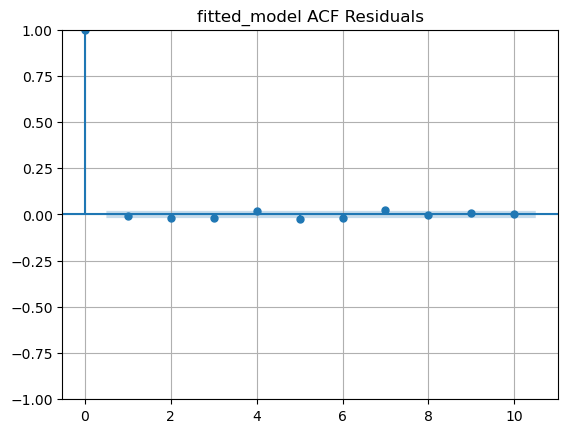

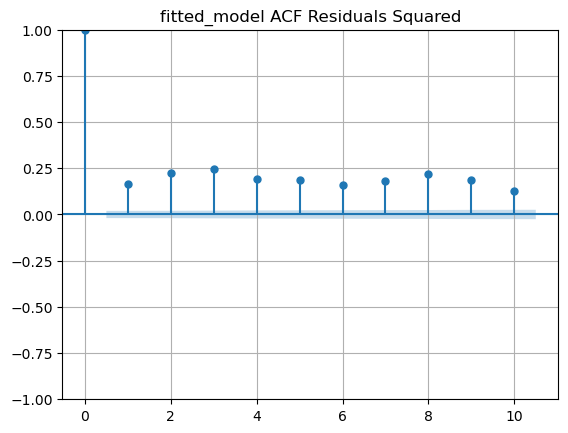

In [38]:
# As part of any decision, the square of the (standardized) residuals should
# be inspected for GARCH effects.

#fitted_model.plot()
sm_api.graphics.tsa.plot_acf(fitted_model.resid, lags=10)
plt.grid()
plt.title("fitted_model ACF Residuals")

sm_api.graphics.tsa.plot_acf(fitted_model.resid**2, lags=10)
plt.grid()
plt.title("fitted_model ACF Residuals Squared")

#the fitted_model residuals and squared residuals indicate that it deals with GARCH model well

# Histogram

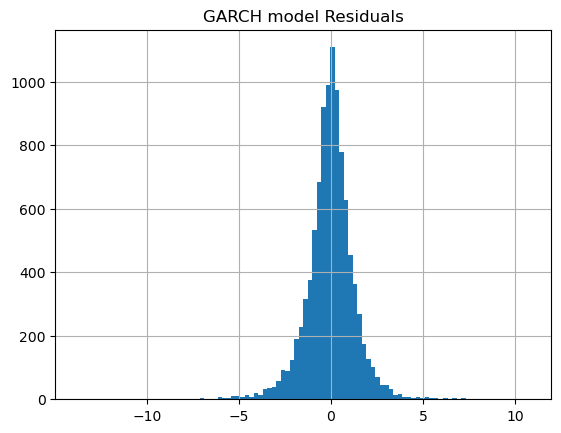

In [40]:
#Plot model as a histogram
fig, ax = plt.subplots()
plt.hist(fitted_model.resid,bins=100,axes=ax)
ax.set_title("GARCH model Residuals")
ax.grid(True)

# qq-plot

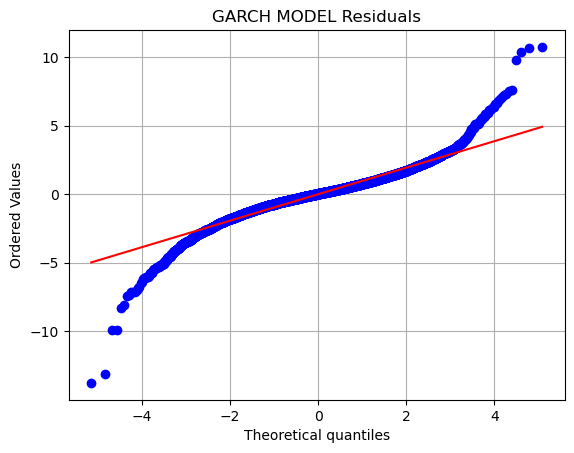

In [42]:
#plot GARCH MODEL as a qq-plot
fig, ax = plt.subplots()
stats.probplot(fitted_model.resid,dist=stats.norm,\
               sparams=(np.mean(fitted_model.resid),np.std(fitted_model.resid)),\
               plot=plt)
ax.set_title("GARCH MODEL Residuals")
ax.grid(True)

## Jaque-bera test

In [45]:
#apply Jaque-bera test for normality of residuals
std_resid = fitted_model.resid / fitted_model.conditional_volatility
# apply Jaque-bera test
jb_stat, jb_p_value = jarque_bera(std_resid)

print(f"Jarque-Bera Statistic: {jb_stat}")
print(f"p-value: {jb_p_value}")

if jb_p_value < 0.05:
    print("Reject the null hypothesis: Residuals are not normally distributed.")
else:
    print("Fail to reject the null hypothesis: Residuals are normally distributed.")


Jarque-Bera Statistic: 19738.52154291363
p-value: 0.0
Reject the null hypothesis: Residuals are not normally distributed.


## 6-2. mean='constant', vol='Garch', p=1, q=1,dist="studentsT"

Text(0.5, 1.0, 'fitted_model ACF Residuals Squared')

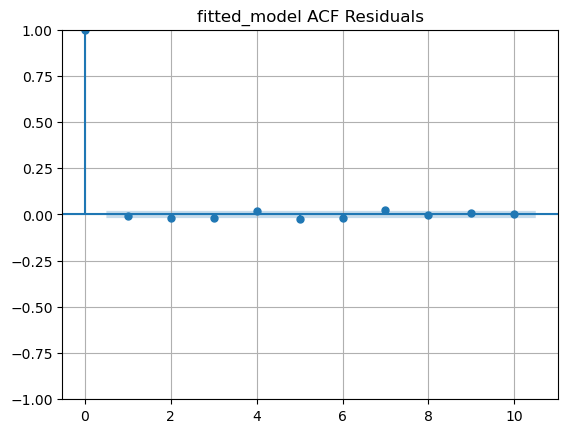

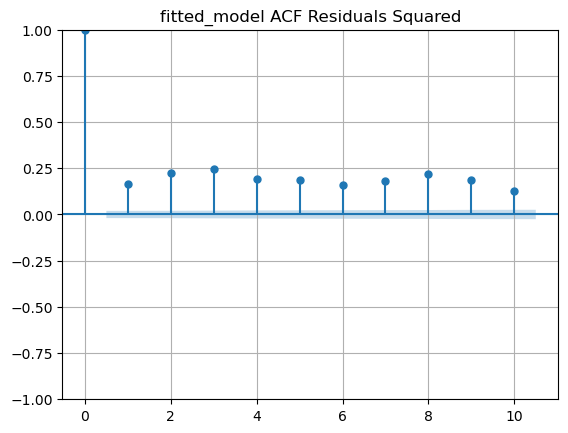

In [47]:
# As part of any decision, the square of the (standardized) residuals should
# be inspected for GARCH effects.

#fitted_model.plot()
sm_api.graphics.tsa.plot_acf(fitted_model_t.resid, lags=10)
plt.grid()
plt.title("fitted_model ACF Residuals")

sm_api.graphics.tsa.plot_acf(fitted_model_t.resid**2, lags=10)
plt.grid()
plt.title("fitted_model ACF Residuals Squared")

#the fitted_model residuals and squared residuals indicate that it deals with GARCH model well

# Histogram

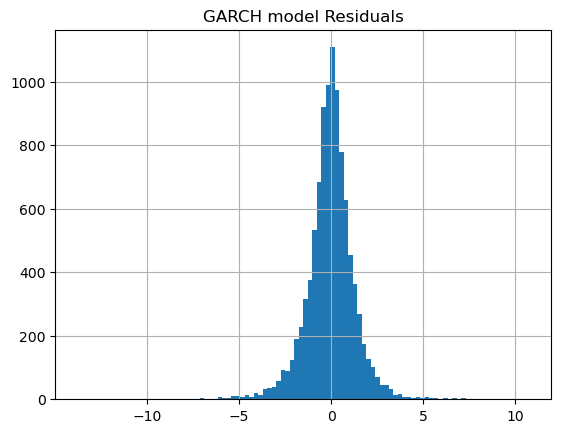

In [49]:
#Plot model as a histogram
fig, ax = plt.subplots()
plt.hist(fitted_model_t.resid,bins=100,axes=ax)
ax.set_title("GARCH model Residuals")
ax.grid(True)

# qq-plot

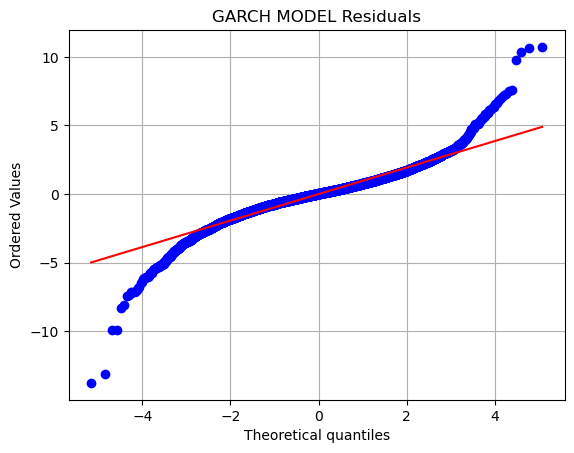

In [51]:
#plot GARCH MODEL as a qq-plot
fig, ax = plt.subplots()
stats.probplot(fitted_model_t.resid,dist=stats.norm,\
               sparams=(np.mean(fitted_model_t.resid),np.std(fitted_model_t.resid)),\
               plot=plt)
ax.set_title("GARCH MODEL Residuals")
ax.grid(True)

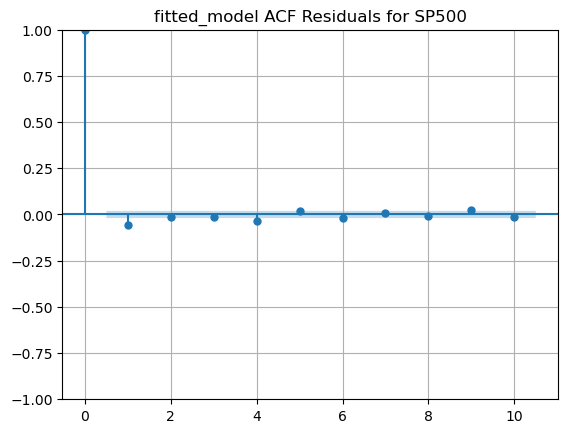

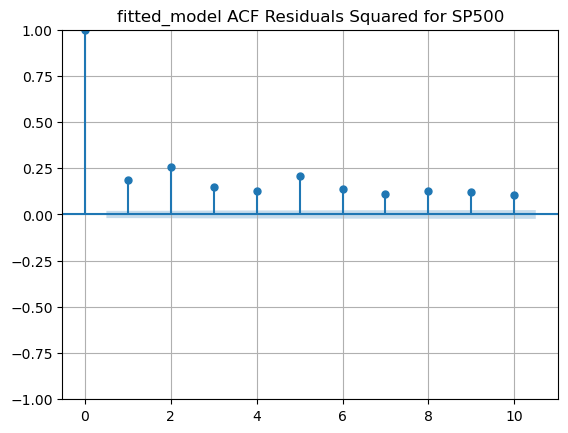

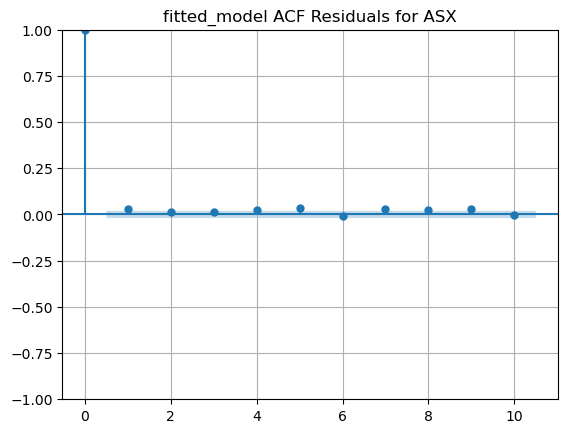

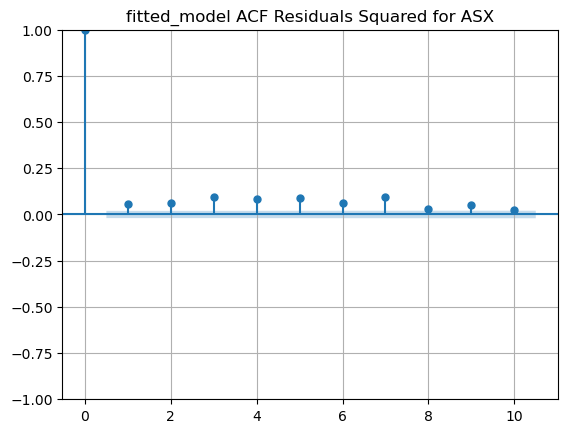

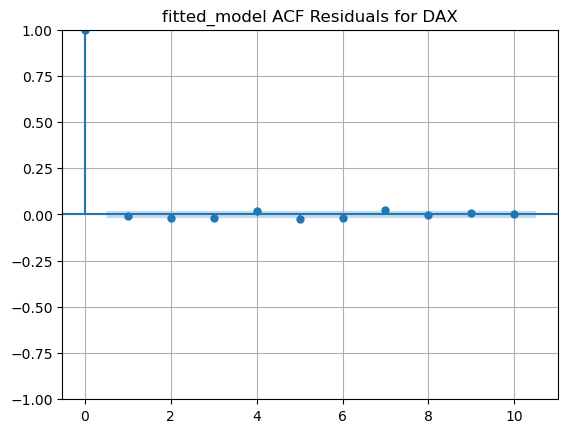

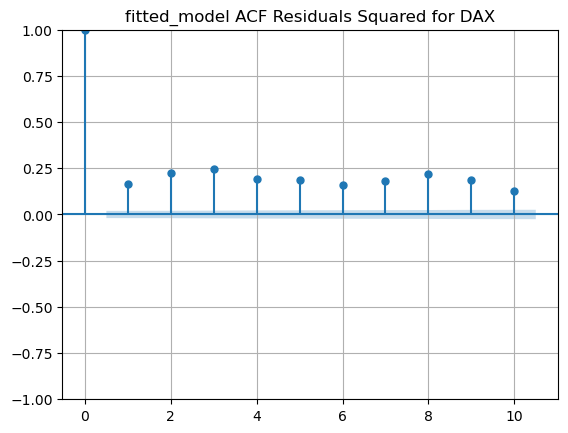

In [52]:
for col in returns.columns:
    model = arch_model(returns[col], vol='Garch', p=1, q=1, dist='t')
    fitted_model_t = model.fit(disp="off")

    sm_api.graphics.tsa.plot_acf(fitted_model_t.resid, lags=10)
    plt.grid()
    plt.title(f"fitted_model ACF Residuals for {col}")

    sm_api.graphics.tsa.plot_acf(fitted_model_t.resid**2, lags=10)
    plt.grid()
    plt.title(f"fitted_model ACF Residuals Squared for {col}")

## 6-3 mean='constant', vol='Garch', p=1, q=1,dist="GED"

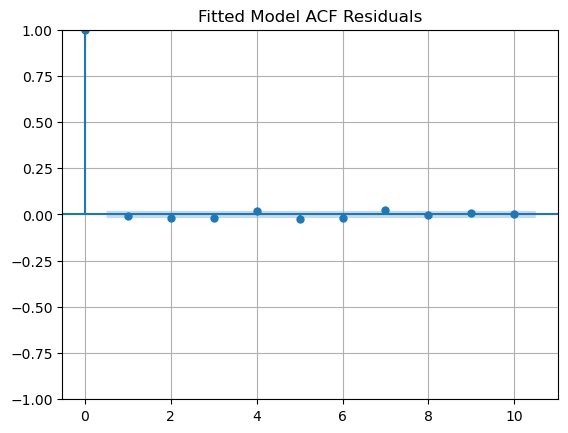

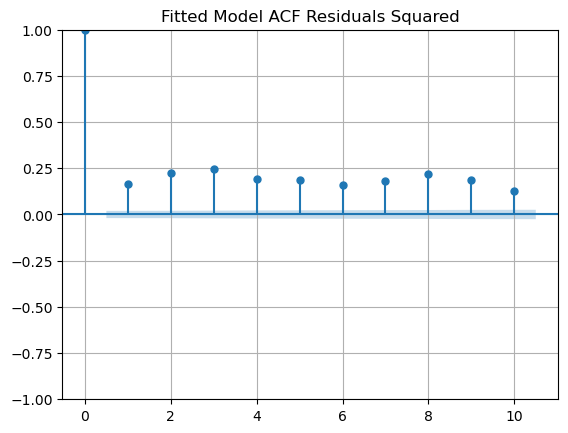

In [55]:
# remove the NaN value
resid_cleaned = fitted_model_g.resid.dropna()

# plot the ACF of residuals
sm_api.graphics.tsa.plot_acf(resid_cleaned, lags=10)
plt.grid()
plt.title("Fitted Model ACF Residuals")
plt.show()

# calcualte the square of residuals, and remove the empty value
resid_squared_cleaned = resid_cleaned**2

# plot the ACF of square residuals
sm_api.graphics.tsa.plot_acf(resid_squared_cleaned, lags=10)
plt.grid()
plt.title("Fitted Model ACF Residuals Squared")
plt.show()

## Histogram

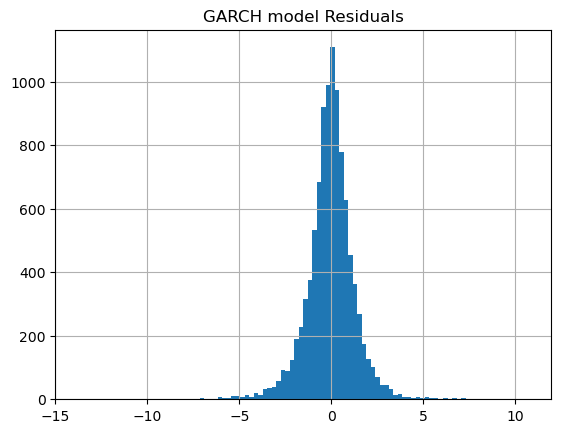

In [60]:
#Plot model as a histogram
fig, ax = plt.subplots()
plt.hist(fitted_model_g.resid,bins=100,axes=ax)
ax.set_title("GARCH model Residuals")
ax.grid(True)

## qq-plot

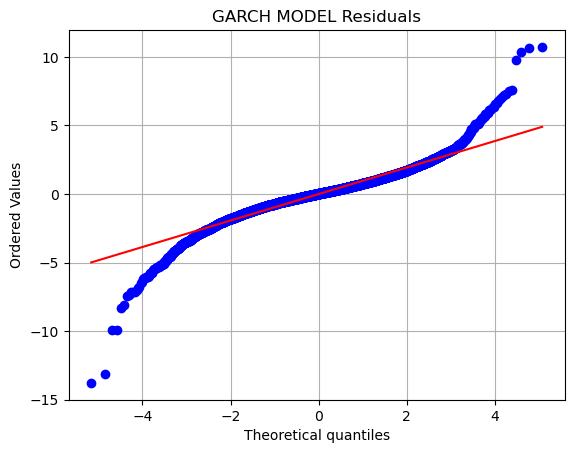

In [63]:
#plot GARCH MODEL as a qq-plot
fig, ax = plt.subplots()
stats.probplot(fitted_model_g.resid,dist=stats.norm,\
               sparams=(np.mean(fitted_model_g.resid),np.std(fitted_model_g.resid)),\
               plot=plt)
ax.set_title("GARCH MODEL Residuals")
ax.grid(True)

## 6-4 mean='AR', vol='Garch', lags=1, p=1, q=1,dist="Normal"

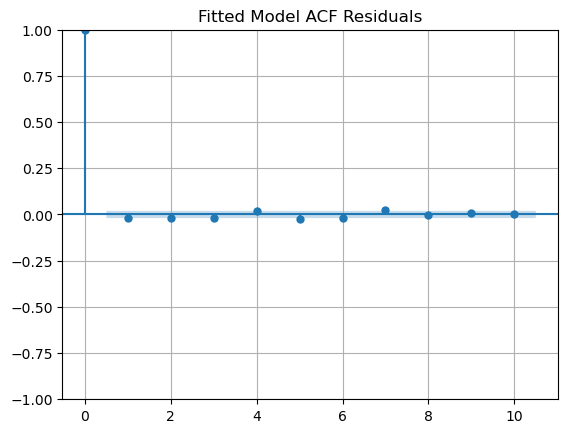

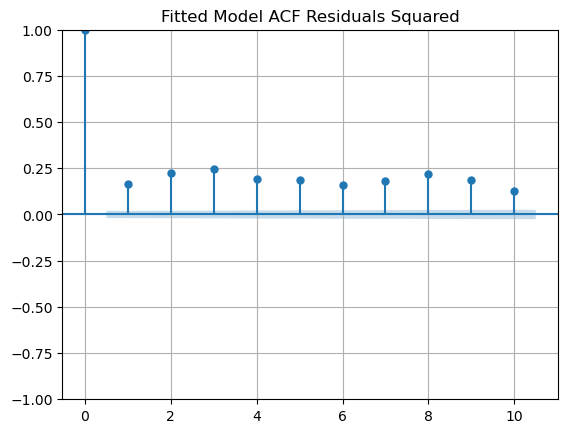

In [66]:
# remove the NaN value
resid_cleaned = fitted_model_AR1.resid.dropna()

# plot the ACF of residuals
sm_api.graphics.tsa.plot_acf(resid_cleaned, lags=10)
plt.grid()
plt.title("Fitted Model ACF Residuals")
plt.show()

# calcualte the square of residuals, and remove the empty value
resid_squared_cleaned = resid_cleaned**2

# plot the ACF of square residuals
sm_api.graphics.tsa.plot_acf(resid_squared_cleaned, lags=10)
plt.grid()
plt.title("Fitted Model ACF Residuals Squared")
plt.show()

## Histogram

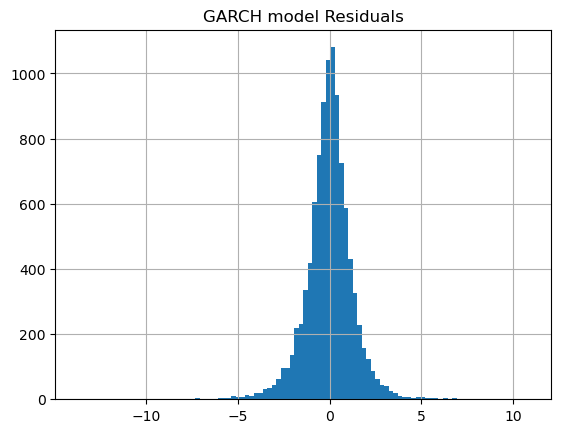

In [68]:
#Plot model as a histogram
fig, ax = plt.subplots()
plt.hist(fitted_model_AR1.resid,bins=100,axes=ax)
ax.set_title("GARCH model Residuals")
ax.grid(True)

## qq-plot

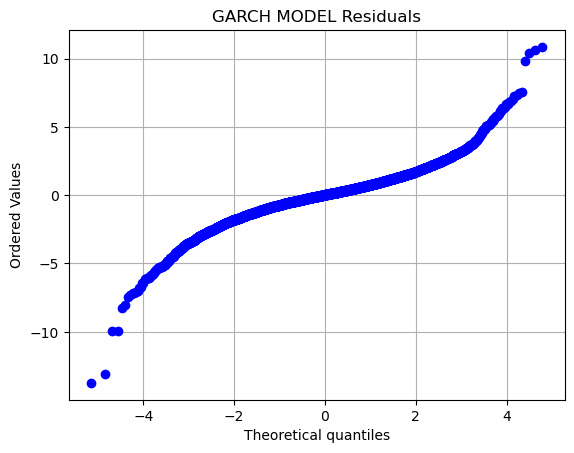

In [70]:
#plot GARCH MODEL as a qq-plot
fig, ax = plt.subplots()
stats.probplot(fitted_model_AR1.resid,dist=stats.norm,\
               sparams=(np.mean(fitted_model_AR1.resid),np.std(fitted_model_AR1.resid)),\
               plot=plt)
ax.set_title("GARCH MODEL Residuals")
ax.grid(True)

## 6-5 mean='AR', vol='Garch', lags=1, p=1, q=1,dist="studentsT"

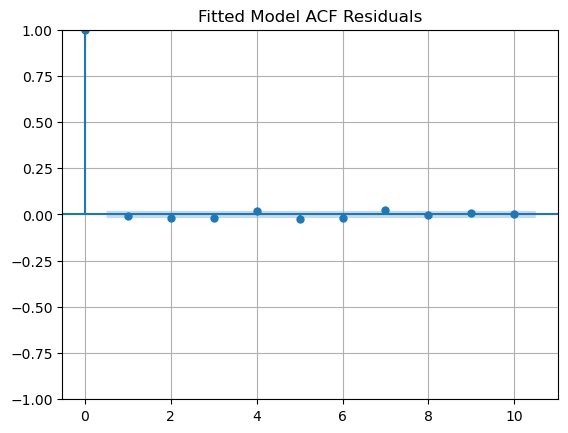

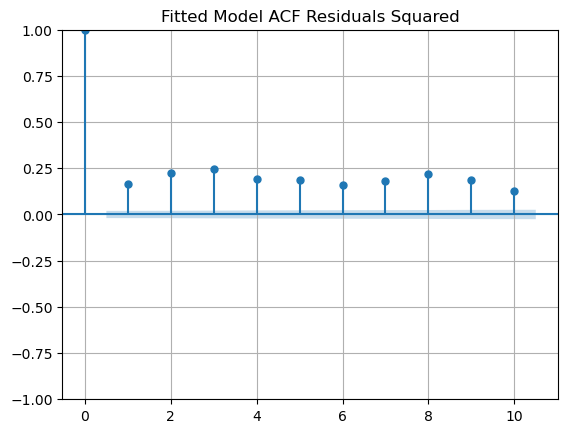

In [72]:
# remove the NaN value
resid_cleaned = fitted_model_AR2.resid.dropna()

# plot the ACF of residuals
sm_api.graphics.tsa.plot_acf(resid_cleaned, lags=10)
plt.grid()
plt.title("Fitted Model ACF Residuals")
plt.show()

# calcualte the square of residuals, and remove the empty value
resid_squared_cleaned = resid_cleaned**2

# plot the ACF of square residuals
sm_api.graphics.tsa.plot_acf(resid_squared_cleaned, lags=10)
plt.grid()
plt.title("Fitted Model ACF Residuals Squared")
plt.show()

## Hisgram

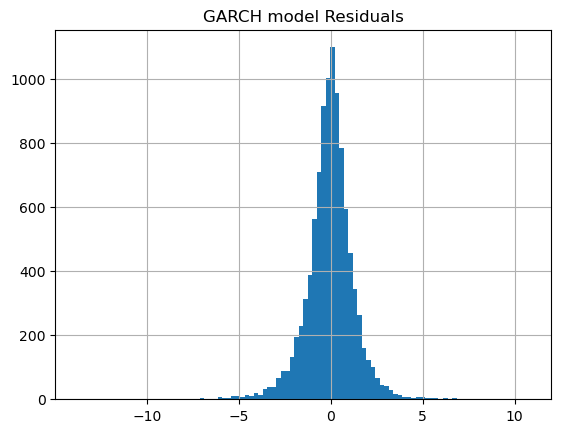

In [74]:
#Plot model as a histogram
fig, ax = plt.subplots()
plt.hist(fitted_model_AR2.resid,bins=100,axes=ax)
ax.set_title("GARCH model Residuals")
ax.grid(True)

## qq plot

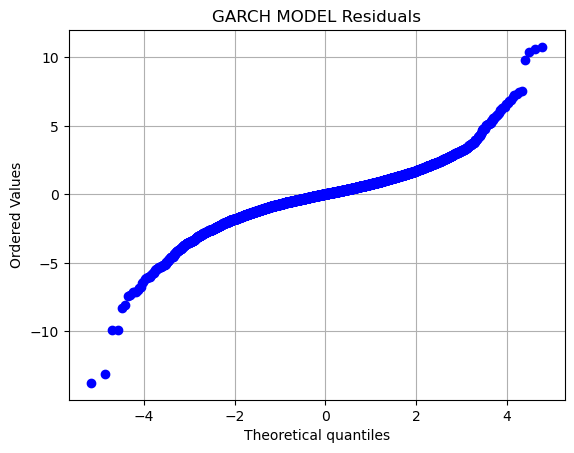

In [76]:
#plot GARCH MODEL as a qq-plot
fig, ax = plt.subplots()
stats.probplot(fitted_model_AR2.resid,dist=stats.norm,\
               sparams=(np.mean(fitted_model_AR2.resid),np.std(fitted_model_AR2.resid)),\
               plot=plt)
ax.set_title("GARCH MODEL Residuals")
ax.grid(True)

## 6-6 mean='AR', vol='Garch', lags=1, p=1, q=1,dist="GED"

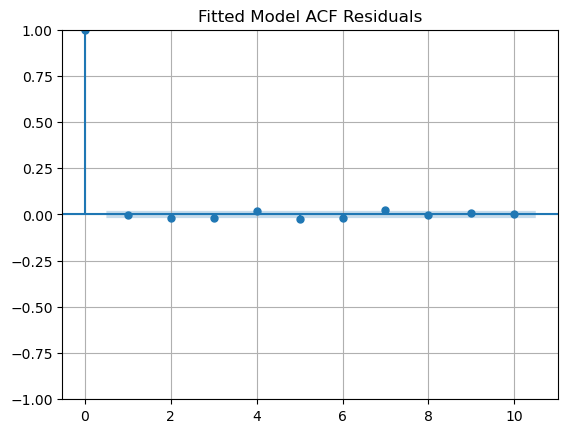

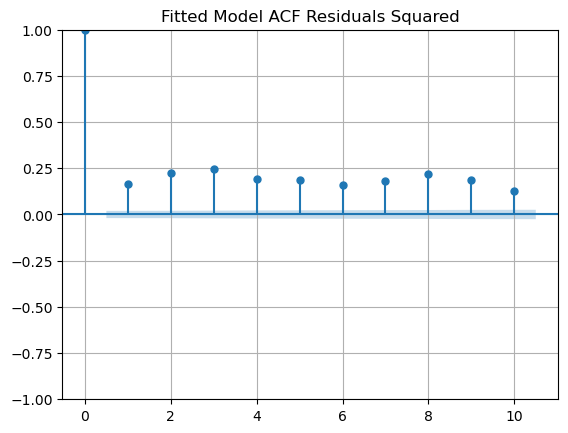

In [78]:
# remove the NaN value
resid_cleaned = fitted_model_AR3.resid.dropna()

# plot the ACF of residuals
sm_api.graphics.tsa.plot_acf(resid_cleaned, lags=10)
plt.grid()
plt.title("Fitted Model ACF Residuals")
plt.show()

# calcualte the square of residuals, and remove the empty value
resid_squared_cleaned = resid_cleaned**2

# plot the ACF of square residuals
sm_api.graphics.tsa.plot_acf(resid_squared_cleaned, lags=10)
plt.grid()
plt.title("Fitted Model ACF Residuals Squared")
plt.show()

## Histogram

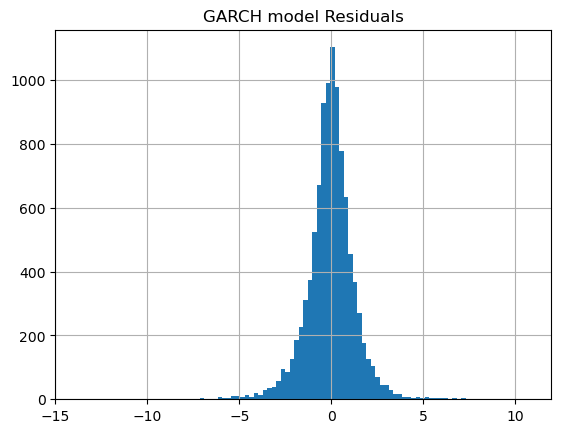

In [81]:
#Plot model as a histogram
fig, ax = plt.subplots()
plt.hist(fitted_model_AR3.resid,bins=100,axes=ax)
ax.set_title("GARCH model Residuals")
ax.grid(True)

## qq plot

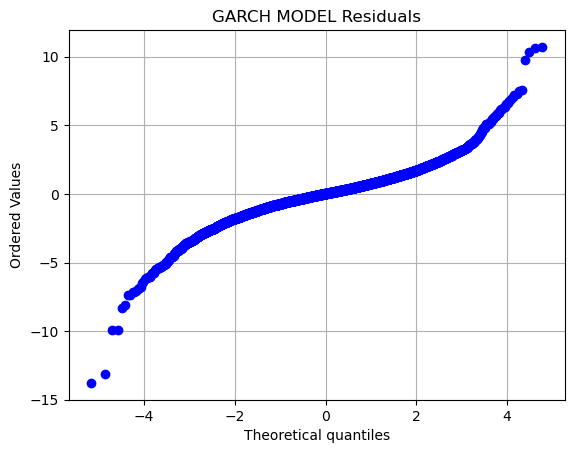

In [83]:
#plot GARCH MODEL as a qq-plot
fig, ax = plt.subplots()
stats.probplot(fitted_model_AR3.resid,dist=stats.norm,\
               sparams=(np.mean(fitted_model_AR3.resid),np.std(fitted_model_AR3.resid)),\
               plot=plt)
ax.set_title("GARCH MODEL Residuals")
ax.grid(True)

## 7. likehood ratio test

In [85]:
#apply likehood ratio test to compare two models (normal distribution vs. student's t distribution)
lr_test = -2 * (fitted_model.loglikelihood - fitted_model_t.loglikelihood)
dof = 1  # Student's t distribution has one more parameter (degree of freedom) than Normal distribution
p_value = stats.chi2.sf(lr_test, dof)

print(f"Likelihood Ratio Test Statistic: {lr_test}")
print(f"P-value: {p_value}")

#apply likehood ratio test to compare two models (AR/normal distribution vs. AR/student's t distribution)
lr_test_AR = -2 * (fitted_model_AR1.loglikelihood - fitted_model_AR2.loglikelihood)
dof = 1  # Student's t distribution has one more parameter (degree of freedom) than Normal distribution
p_value_AR = stats.chi2.sf(lr_test_AR, dof)

print(f"Likelihood Ratio Test Statistic of AR model: {lr_test_AR}")
print(f"P-value: {p_value_AR}")

#apply likehood ratio test to compare two models (constant student's distribution vs. AR/student's t distribution)
lr_test_3 = -2 * (fitted_model_AR2.loglikelihood - fitted_model_t.loglikelihood)
dof = 1  # Student's t distribution has one more parameter (degree of freedom) than Normal distribution
p_value_3 = stats.chi2.sf(lr_test_3, dof)

print(f"Likelihood Ratio Test Statistic of AR model: {lr_test_3}")
print(f"P-value: {p_value_3}")



Likelihood Ratio Test Statistic: 577.5362794903558
P-value: 1.2882259255886386e-127
Likelihood Ratio Test Statistic of AR model: 575.5762244117795
P-value: 3.4383355775944816e-127
Likelihood Ratio Test Statistic of AR model: -6.647251786540437
P-value: 1.0


In [87]:
#apply likehood test to compare two models (error distribution vs. student's t distribution)

log_likelihood_t = fitted_model_t.loglikelihood
log_likelihood_ged = fitted_model_g.loglikelihood

print(f"Log-Likelihood for Student's t model: {log_likelihood_t}")
print(f"Log-Likelihood for GED model: {log_likelihood_ged}")

if log_likelihood_t > log_likelihood_ged:
    print("Student's t model fits the data better.")
elif log_likelihood_t < log_likelihood_ged:
    print("GED model fits the data better.")
else:
    print("Both models fit the data equally well.")


Log-Likelihood for Student's t model: -15352.840120930327
Log-Likelihood for GED model: -15402.673921064183
Student's t model fits the data better.
